<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/My_Custom_Ensemble_MAX_With_Complete_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from os import listdir

files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_train/')


In [3]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 


In [4]:
pip install tensorflow_decision_forests


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 4.3 MB/s 
     |████████████████████████████████| 511.7 MB 4.7 kB/s 
     |████████████████████████████████| 1.6 MB 52.4 MB/s 
     |████████████████████████████████| 438 kB 56.4 MB/s 
     |████████████████████████████████| 5.8 MB 38.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [5]:
import gc 

import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.layers import GRU, Dense
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf



In [6]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'
AGG_DATA_ABS_PATH = '/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet'

In [7]:
!unzip -o /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip \
 train_labels.csv

Archive:  /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip
  inflating: train_labels.csv        


In [8]:
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

In [9]:
train_labels.shape

(458913, 2)

In [10]:
agg_dataset = pd.read_parquet(path=AGG_DATA_ABS_PATH)

In [11]:
enc_agg = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
agg_dataset[['D_63_last', 'D_64_last']]=enc_agg.fit(agg_dataset[['D_63_last', 'D_64_last']])
agg_dataset[['D_63_last', 'D_64_last']]=enc_agg.transform(agg_dataset[['D_63_last', 'D_64_last']])
agg_dataset.fillna(0, inplace=True)



In [12]:
agg_dataset.drop(axis=1, columns=['target'], inplace=True)

In [13]:
agg_dataset.shape

(458913, 919)

In [14]:
def append_label(source_df):
  return pd.merge(left=source_df, right=train_labels, how='inner')

In [15]:
df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_train/0_50000.parquet')
df_tmp = append_label(df_tmp)

In [16]:
len(df_tmp.columns)

191

In [17]:
df_tmp.iloc[0:10, -10:]

,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0
5,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884,0
6,NaN,NaN,0.001336,0.004361,0.009387,NaN,0.007727,0.007661,0.002225,0
7,NaN,NaN,0.002397,0.008452,0.005553,NaN,0.001831,0.009616,0.007385,0
8,NaN,NaN,0.009742,0.003968,0.007945,NaN,0.008722,0.004369,0.000995,0
9,NaN,NaN,0.003611,0.009607,0.007266,NaN,0.008763,0.004753,0.009068,0


In [18]:
df_tmp.tail()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
602911,1c07145aef6408092ef9f94270699f6f671ec7c9093277...,2017-11-08,0.837833,0.006710,0.038680,0.097863,0.002265,0.232981,0.152760,0.069115,...,NaN,NaN,0.003875,0.006231,0.003193,NaN,0.005696,0.009711,0.003060,0
602912,1c07145aef6408092ef9f94270699f6f671ec7c9093277...,2017-12-27,0.781706,0.564507,0.039073,1.002404,0.006559,0.161594,0.141727,0.025914,...,NaN,NaN,0.004343,0.000891,0.006571,NaN,0.000498,0.007017,0.008835,0
602913,1c07145aef6408092ef9f94270699f6f671ec7c9093277...,2018-01-24,0.788243,0.833296,0.048927,1.001389,0.008626,0.156342,0.136205,0.023727,...,NaN,NaN,0.008752,0.000125,0.006323,NaN,0.002858,0.002037,0.003747,0
602914,1c07145aef6408092ef9f94270699f6f671ec7c9093277...,2018-02-13,0.842575,0.533355,0.034230,0.867164,0.007749,0.160544,0.133761,0.022605,...,NaN,NaN,0.005521,0.006413,0.008679,NaN,0.006674,0.002432,0.008648,0
602915,1c07145aef6408092ef9f94270699f6f671ec7c9093277...,2018-03-28,0.858625,0.562265,0.020487,1.004100,0.006003,0.153542,0.006859,0.021063,...,NaN,NaN,0.004774,0.005442,0.003818,NaN,0.002680,0.008393,0.002955,0


In [19]:
print(f'df.columns len = {len(df_tmp.columns)}')
print(f'df[:, 0:100] shape = {df_tmp.iloc[:, 0:100].shape}')
print(f'df[:, 100:188] = {df_tmp.iloc[:, 100:191].shape}')

df.columns len = 191
df[:, 0:100] shape = (602916, 100)
df[:, 100:188] = (602916, 91)


In [20]:
del df_tmp

In [21]:
def my_generator():
    for f in files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_train/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')

      X_Agg = pd.merge(left=X_Cust, right=agg_dataset, how ='inner')
      
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      
      X_3D = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)

      X_Agg.drop(axis=1, columns='customer_ID', inplace=True)
      col_count = len(X.columns)
      # print(f'X shape = {X.shape}')
      # print(f'X_3D shape = {X_3D.shape}')
      # print(f'X[:, 0:100] shape = {X_Agg.iloc[:, 0:500].shape}')
      # print(f'X[:, 100:188] = {X_Agg.iloc[:, 500:918].shape}')

      yield {"input_1": X_3D, "input_2": X_Agg.to_numpy(), 
             "input_3": X_Agg.iloc[:, 0:500].to_numpy(),
             "input_4": X_Agg.iloc[:, 500:918].to_numpy()}, Y.to_numpy()
      




In [22]:
def my_input_fn(epochs):
    dataset = tf.data.Dataset.from_generator(lambda: my_generator(),
                                             output_types=({"input_1": tf.float64, "input_2": tf.float64, "input_3": tf.float64, "input_4": tf.float64}, tf.int64),
                                            output_shapes=({"input_1": tf.TensorShape([None, 13, 188]), "input_2" : tf.TensorShape([None, 918]),
                                                            "input_3" : tf.TensorShape([None, 500]), "input_4" : tf.TensorShape([None, 418])},
                                                           tf.TensorShape([None, 1])))

    dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset


In [23]:
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

first_input = tf.keras.Input(shape=(13, 188))
first_dense_1 = GRU(64, dropout=0.1, recurrent_dropout=0.5)(first_input)
first_dense_2 = Dense(64, activation='sigmoid')(first_dense_1)
m1_pred = Dense(1, activation='sigmoid')(first_dense_2)

second_input = tf.keras.Input(shape=(918))
second_dense_1 = Dense(128, activation='relu')(second_input)
second_dense_2 = Dense(64, activation='sigmoid')(second_dense_1)
m2_pred = Dense(1, activation='sigmoid')(second_dense_2)


third_input = tf.keras.Input(shape=(500))
third_dense_1 = Dense(128, activation='relu')(third_input)
third_dense_2 = Dense(64, activation='sigmoid')(third_dense_1)
m3_pred = Dense(1, activation='sigmoid')(third_dense_2)

fourth_input = tf.keras.Input(shape=(418))
fourth_dense_1 = Dense(128, activation='relu')(fourth_input)
fourth_dense_2 = Dense(64, activation='sigmoid')(fourth_dense_1)
m4_pred = Dense(1, activation='sigmoid')(fourth_dense_2)

max_of_all_model = tf.reduce_max(tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)


# Keras Models
# ============
ensemble_max_of_all_model =  tf.keras.models.Model(inputs=[first_input, second_input, third_input, fourth_input], outputs=max_of_all_model)


ensemble_max_of_all_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy", f1_metric])




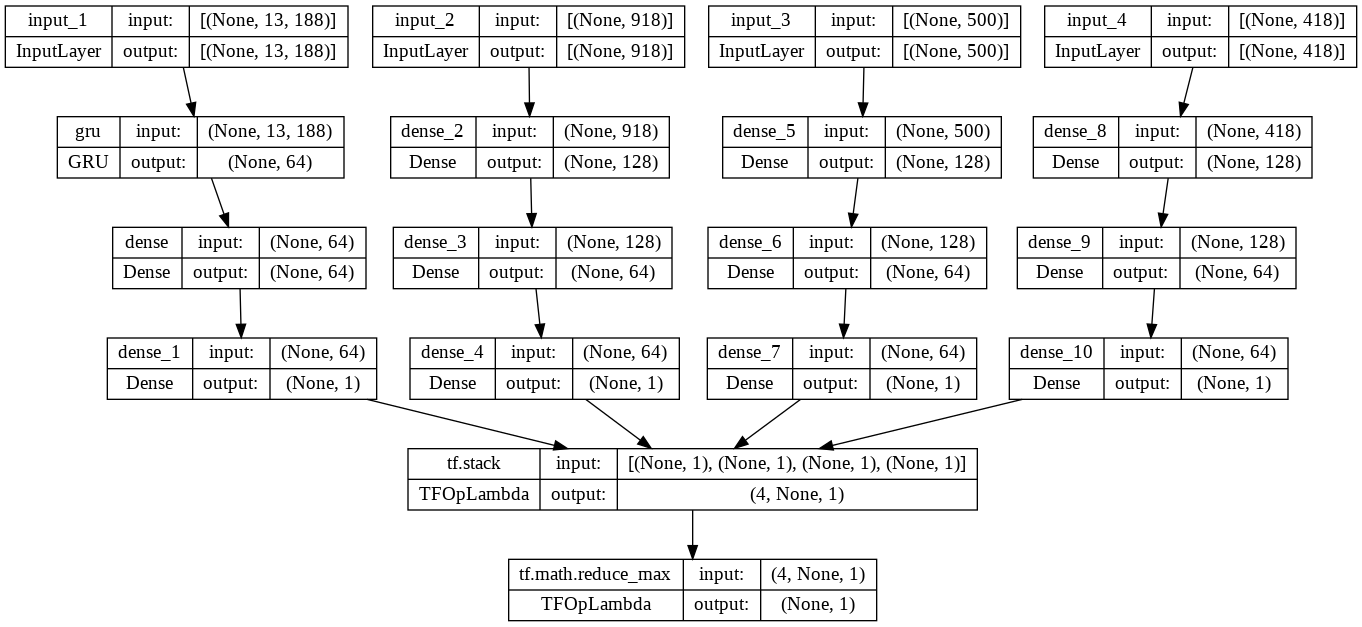

In [24]:


from keras.utils.vis_utils import plot_model

plot_model(ensemble_max_of_all_model, to_file="/tmp/model.png", show_shapes=True)

In [25]:

dataset = my_input_fn(1)



In [26]:
ensemble_max_of_all_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 188)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 918)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 418)]        0           []                               
                                                                                              

In [27]:
ensemble_max_of_all_model.fit(dataset, epochs=2)

Epoch 1/2
8/8 [==============================] - 257s 34s/step - loss: 0.6610 - accuracy: 0.6284 - f1_score: 0.3237
Epoch 2/2
8/8 [==============================] - 171s 23s/step - loss: 0.4685 - accuracy: 0.7747 - f1_score: 0.0598


In [28]:
val_files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_val/')

In [29]:
def my_val_generator():
    for f in val_files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_val/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')

      X_Agg = pd.merge(left=X_Cust, right=agg_dataset, how ='inner')
      
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      
      X_3D = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)

      X_Agg.drop(axis=1, columns='customer_ID', inplace=True)
      col_count = len(X.columns)
      print(f'X shape = {X.shape}')
      print(f'X_3D shape = {X_3D.shape}')
      print(f'X[:, 0:100] shape = {X_Agg.iloc[:, 0:500].shape}')
      print(f'X[:, 100:188] = {X_Agg.iloc[:, 500:918].shape}')

      yield {"input_1": X_3D, "input_2": X_Agg.to_numpy(), 
             "input_3": X_Agg.iloc[:, 0:500].to_numpy(),
             "input_4": X_Agg.iloc[:, 500:918].to_numpy()}, Y.to_numpy()



In [30]:
def my_val_input_fn():
    dataset = tf.data.Dataset.from_generator(lambda: my_val_generator(),
                                             output_types=({"input_1": tf.float64, "input_2": tf.float64, "input_3": tf.float64, "input_4": tf.float64}, tf.int64),
                                            output_shapes=({"input_1": tf.TensorShape([None, 13, 188]), "input_2" : tf.TensorShape([None, 918]),
                                                            "input_3" : tf.TensorShape([None, 500]), "input_4" : tf.TensorShape([None, 418])},
                                                           tf.TensorShape([None, 1])))

    # dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset

In [31]:
val_dataset = my_val_input_fn()
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
ensemble_max_of_all_model.compile(metrics=["accuracy", f1_metric])
print("Evaluation:", ensemble_max_of_all_model.evaluate(val_dataset))

X shape = (548522, 188)
X_3D shape = (42194, 13, 188)
X[:, 0:100] shape = (42194, 500)
X[:, 100:188] = (42194, 418)
1/1 [==============================] - 33s 33s/step - loss: 0.0000e+00 - accuracy: 0.7840 - f1_score: 0.1231
Evaluation: [0.0, 0.7839503288269043, array([0.12312426], dtype=float32)]
